### Goals: engineer features that highlight the time dimesionality of the data and test out four different algorithms

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#load dataset
df=pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')
#fill NaNs
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#to datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
#extract month to new column
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month

In [3]:
df=pd.merge(df, labels, on=['city', 'year', 'weekofyear'])

## preprocessing - just experimenting here to figure out what features will help increase predictive performance

#### lag columns, take rolling averages, historical dengue counts

In [4]:
#idea historical average dengue counts and climate for that week in the year

In [5]:
#for each city, on that week, what is the avg num cases and overall std over the years?
df=df.join(df.groupby(['city','weekofyear'])['total_cases'].mean(), on=['city','weekofyear'], rsuffix='_avg')
df=df.join(df.groupby(['city','weekofyear'])['total_cases'].std(), on=['city','weekofyear'], rsuffix='_std')

In [6]:
#for each city, on that week, what is the avg num cases and overall std over the years?
test=test.join(df.groupby(['city','weekofyear'])['total_cases'].mean(), on=['city','weekofyear'], rsuffix='_avg')
test=test.join(df.groupby(['city','weekofyear'])['total_cases'].std(), on=['city','weekofyear'], rsuffix='_std')

In [7]:
#quick column fix
test.rename(columns={'total_cases': 'total_cases_avg'}, inplace=True)
test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month,total_cases_avg,total_cases_std
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,4,10.722222,9.144626
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,5,9.944444,8.881390
2,sj,2008,20,2008-05-13,-0.0015,-0.012400,0.151083,0.091529,3.66,299.455714,...,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5,11.500000,11.510864
3,sj,2008,21,2008-05-20,-0.0015,-0.019867,0.124329,0.125686,0.00,299.690000,...,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5,11.166667,12.234234
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,5,13.777778,10.919791


In [8]:
# #plan to lag these columns 3 weeks 
# #this lag did not greatly improve model performance, the rolling avg was better
cols_to_lag=[
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_precip_mm',
 ]

In [9]:
for col in cols_to_lag:
    df['lagged_'+col] = df[col].shift(2)

for col in cols_to_lag:
    test['lagged_'+col] = test[col].shift(2)

In [10]:
lagged_cols=[

 'lagged_precipitation_amt_mm',
 'lagged_reanalysis_air_temp_k',
 'lagged_reanalysis_avg_temp_k',
 'lagged_reanalysis_dew_point_temp_k',
 'lagged_reanalysis_max_air_temp_k',
 'lagged_reanalysis_min_air_temp_k',
 'lagged_reanalysis_precip_amt_kg_per_m2',
 'lagged_reanalysis_relative_humidity_percent',
 'lagged_reanalysis_sat_precip_amt_mm',
 'lagged_reanalysis_specific_humidity_g_per_kg',
 'lagged_reanalysis_tdtr_k',
 'lagged_station_precip_mm',
]

In [11]:
# #fill NaNs after the lag
# df=df.fillna(df.groupby("month").transform(lambda x: x.fillna(x.mean())))
# test=test.fillna(test.groupby("month").transform(lambda x: x.fillna(x.mean())))

In [12]:
#define cols for moving avg
feature_cols1=[
    'reanalysis_min_air_temp_k',
    #'month',
    'reanalysis_air_temp_k',
    'reanalysis_avg_temp_k',
    'reanalysis_dew_point_temp_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_sat_precip_amt_mm',
    'ndvi_ne',
    'ndvi_nw',
    'ndvi_se',
    'ndvi_sw',
    ]

In [13]:
#loop to make the columns with rolling averages on independent vars
#takes the avg of prior 3 weeks
for col in feature_cols1:
    df['rolling_'+col] = pd.rolling_mean(df[col], 3)
    test['rolling_'+col] = pd.rolling_mean(df[col], 3)

In [14]:
for col in feature_cols1:
    df['wk_avg_'+col] = df.groupby(['city','weekofyear'])[col].transform('mean')
    test['wk_avg_'+col] = test.groupby(['city','weekofyear'])[col].transform('mean')

In [15]:
for col in feature_cols1:
    df['mo_avg_'+col] = df.groupby(['city','month'])[col].transform('mean')
    test['mo_avg_'+col] = test.groupby(['city','month'])[col].transform('mean')

In [16]:
# # #engineer column to identify worst months for dengue in each location
# #this didn't help much either so am commenting it out here
# def bad_mo_sj (x):
#     if x == 10: return 1
#     if x == 11: return 1
#     if x == 9: return 1
#     return 0

# def bad_mo_iq (x):
#     if x == 1: return 1
#     if x == 12: return 1
#     if x == 2: return 1
#     return 0

In [17]:
# #create the new column
# sj['key_months'] = sj.month.apply(bad_mo_sj)
# iq['key_months'] = iq.month.apply(bad_mo_iq)
# sj_test['key_months'] = sj_test.month.apply(bad_mo_sj)
# iq_test['key_months'] = iq_test.month.apply(bad_mo_iq)

In [18]:
# lagged_features=[
#     'lagged_reanalysis_min_air_temp_k',
#     'month',
#     'lagged_reanalysis_air_temp_k',
#     'lagged_reanalysis_avg_temp_k',
#     'lagged_reanalysis_dew_point_temp_k',
#     'lagged_reanalysis_sat_precip_amt_mm',
#     'lagged_reanalysis_specific_humidity_g_per_kg',
#     'mo_avg_reanalysis_min_air_temp_k',
#     'mo_avg_reanalysis_air_temp_k',
#     'mo_avg_reanalysis_avg_temp_k',
#     'mo_avg_reanalysis_dew_point_temp_k'
#     'mo_avg_reanalysis_specific_humidity_g_per_kg',
#     'mo_avg_reanalysis_sat_precip_amt_mm',
#     'mo_avg_ndvi_ne',
#     'ndvi_ne',
#     'mo_avg_ndvi_nw',
#     'mo_avg_ndvi_se',
#     'mo_avg_ndvi_sw',
#     'key_months']

### I tried out many, many combinations of the features below

In [19]:
features=[
# #  'city',
#  'year',
  'weekofyear',
# #  'week_start_date',
# #  'ndvi_ne',
# #  'ndvi_nw',
# #  'ndvi_se',
# #  'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
   'reanalysis_avg_temp_k', ##to use
   'reanalysis_dew_point_temp_k',##to use
# #  'reanalysis_max_air_temp_k',
   'reanalysis_min_air_temp_k',##to use
# #  'reanalysis_precip_amt_kg_per_m2',
# #  'reanalysis_relative_humidity_percent',
# #  'reanalysis_sat_precip_amt_mm',
   'reanalysis_specific_humidity_g_per_kg',##to use
#   'reanalysis_tdtr_k',
#   'station_avg_temp_c',
#   'station_diur_temp_rng_c',
#   'station_max_temp_c',
#   'station_min_temp_c',
#   'station_precip_mm',
 'month',
# #  'total_cases',  #can't have target in feat list now can we lol
  'total_cases_avg',
# #  'total_cases_std',
  'mo_avg_reanalysis_min_air_temp_k',
 'mo_avg_reanalysis_air_temp_k',
 #'mo_avg_reanalysis_avg_temp_k',
 'mo_avg_reanalysis_dew_point_temp_k',
  'mo_avg_reanalysis_specific_humidity_g_per_kg',
#  'mo_avg_reanalysis_sat_precip_amt_mm',
# #  'mo_avg_ndvi_ne',
# #  'mo_avg_ndvi_nw',
# #  'mo_avg_ndvi_se',
# #  'mo_avg_ndvi_sw',
#   'wk_avg_reanalysis_min_air_temp_k',
# #  'wk_avg_reanalysis_air_temp_k',
#   'wk_avg_reanalysis_avg_temp_k',
#   'wk_avg_reanalysis_dew_point_temp_k',
#   'wk_avg_reanalysis_specific_humidity_g_per_kg',
# #  'wk_avg_reanalysis_sat_precip_amt_mm',
#  'wk_avg_ndvi_ne',
#  'wk_avg_ndvi_nw',
#  'wk_avg_ndvi_se',
#  'wk_avg_ndvi_sw',
#   'rolling_reanalysis_min_air_temp_k',
#   'rolling_reanalysis_air_temp_k',
# #  'rolling_reanalysis_avg_temp_k',
#   'rolling_reanalysis_dew_point_temp_k',
#   'rolling_reanalysis_specific_humidity_g_per_kg',
# #  'rolling_reanalysis_sat_precip_amt_mm'
# #    'key_months'
#  'lagged_precipitation_amt_mm',
#  'lagged_reanalysis_air_temp_k',
#   'lagged_reanalysis_avg_temp_k',
#   'lagged_reanalysis_dew_point_temp_k',
# #  'lagged_reanalysis_max_air_temp_k',
#   'lagged_reanalysis_min_air_temp_k',
# #  'lagged_reanalysis_precip_amt_kg_per_m2',
# #  'lagged_reanalysis_relative_humidity_percent',
# #  'lagged_reanalysis_sat_precip_amt_mm',
#   'lagged_reanalysis_specific_humidity_g_per_kg',
#  'lagged_reanalysis_tdtr_k',
#  'lagged_station_precip_mm',
 ]

In [20]:
#fill resulting NaNs from the lag functions
df.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

In [21]:
df.to_csv('train_edited.csv')

In [22]:
# separate san juan and iquitos
sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

sj_test=test[test['city']=='sj']
iq_test=test[test['city']=='iq']

## Algorithms for comparison

In [23]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [24]:
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

LR: -27.334679 (14.158445)
DT: -36.650755 (12.873181)
RFR: -30.135382 (13.954505)
SVR: -22.747621 (18.143094)


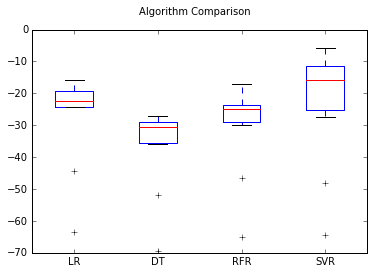

In [25]:
#code reference: Machine Learning Mastery - http://machinelearningmastery.com/
#set x and y

X= sj[features]
Y = sj['total_cases']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: -6.794044 (1.506963)
DT: -8.315385 (2.437400)
RFR: -7.409808 (1.885796)
SVR: -6.061310 (2.617470)


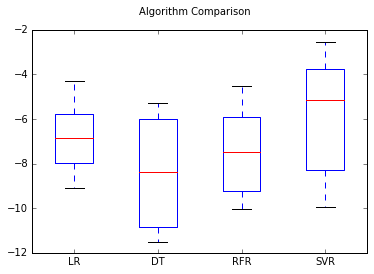

In [26]:
## IQUITOS
X= iq[features]
Y = iq['total_cases']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### visualize the importances of selected features

Feature ranking:
1. feature 1 (0.252675)
2. feature 2 (0.241635)
3. feature 6 (0.187359)
4. feature 4 (0.150517)
5. feature 0 (0.085725)
6. feature 3 (0.069117)
7. feature 7 (0.007964)
8. feature 10 (0.002060)
9. feature 8 (0.001361)
10. feature 9 (0.000881)
11. feature 5 (0.000706)


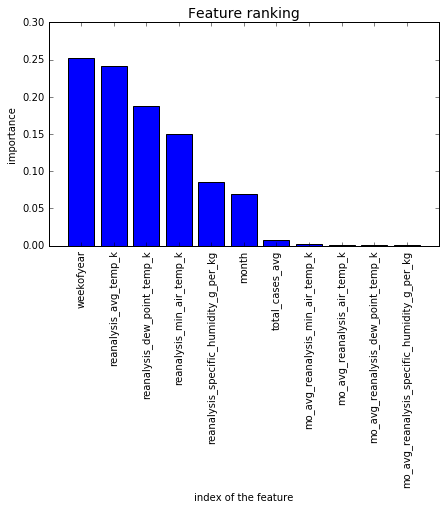

In [27]:
X= sj[features]
Y = sj['total_cases']

model =DecisionTreeRegressor()
model.fit(X,Y)
model.predict(sj_test[features])

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

feature_names = X.columns

f, ax = plt.subplots(figsize=(7, 4))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 10)
plt.xlabel("index of the feature", fontsize = 10)

Feature ranking:
1. feature 1 (0.291184)
2. feature 6 (0.189720)
3. feature 3 (0.173528)
4. feature 4 (0.162601)
5. feature 2 (0.113535)
6. feature 0 (0.039786)
7. feature 7 (0.011293)
8. feature 5 (0.006909)
9. feature 8 (0.004574)
10. feature 9 (0.003681)
11. feature 10 (0.003189)


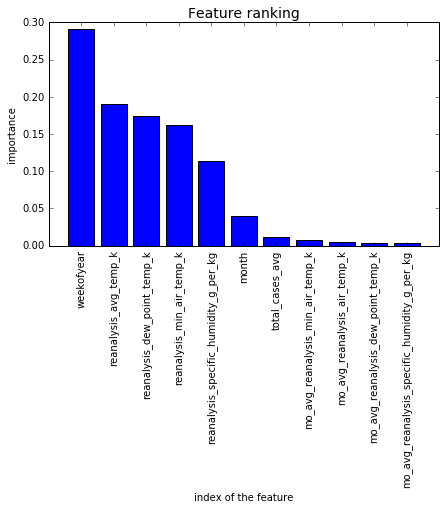

In [28]:
X= iq[features]
Y = iq['total_cases']

model =DecisionTreeRegressor()
model.fit(X,Y)
model.predict(iq_test[features])

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

feature_names = X.columns

f, ax = plt.subplots(figsize=(7, 4))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 10)
plt.xlabel("index of the feature", fontsize = 10)

### perform gridsearch on support vector regressor

In [29]:
from sklearn.model_selection import GridSearchCV
import time as time

In [30]:
X_sj= sj[features]
Y_sj = sj['total_cases']

X_iq= iq[features]
Y_iq = iq['total_cases']

In [31]:
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_sj,Y_sj)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 7.523 s


In [32]:
model_svr_sj=svr.best_estimator_
model_svr_sj

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [33]:
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_iq,Y_iq)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 4.743 s


In [34]:
model_svr_iq=svr.best_estimator_
model_svr_iq

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
model_svr_sj.fit(X_sj,Y_sj)
model_svr_iq.fit(X_iq,Y_iq)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
# test_model=SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#   gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
#   tol=0.001, verbose=False)

In [37]:
# test_model_iq=SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#   gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
#   tol=0.001, verbose=False)

In [38]:
# test_model.fit(sj_train_subtrain[features], sj_train_subtrain['total_cases'])

In [39]:
# test_model_iq.fit(iq_train_subtrain[features], iq_train_subtrain['total_cases'])

In [40]:
preds_sj_svr= model_svr_sj.predict(sj_train_subtest[features]).astype(int)
preds_iq_svr=model_svr_iq.predict(iq_train_subtest[features]).astype(int)

In [41]:
sj_train_subtest['fitted'] = preds_sj_svr
iq_train_subtest['fitted'] = preds_iq_svr

In [42]:
sj_train_subtest['fitted'] = preds_sj_svr
iq_train_subtest['fitted'] = preds_iq_svr
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']

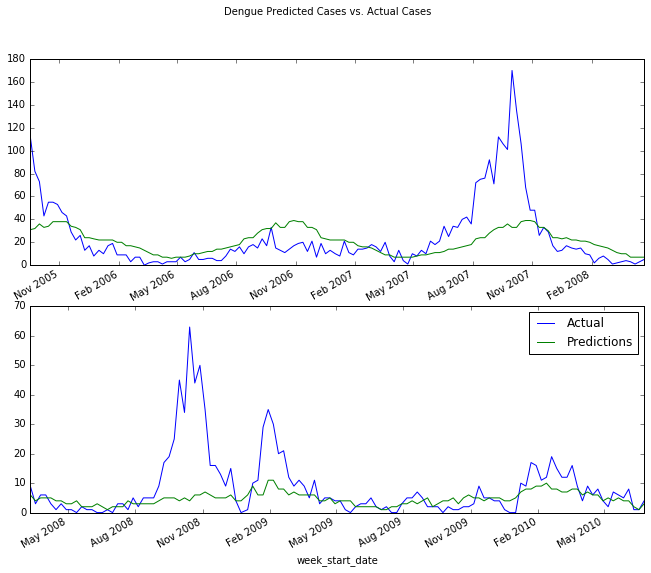

In [43]:
sj_train_subtest['fitted'] = preds_sj_svr
iq_train_subtest['fitted'] = preds_iq_svr
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']

figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_train_subtest.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[0], label="Predictions")

iq_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
iq_train_subtest.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## not satisfactory at all

### clearly the model is unable to predict the spikes in disease outbreak
#### I need to somehow account for the cases in previous weeks - either true or predicted
#### Idea: use historical counts and/or predicted vals in the testing set where we have no counts and train the model using previous week counts as a feature

In [50]:
preds_sj_svr= model_svr_sj.predict(sj_test[features]).astype(float)
preds_iq_svr=model_svr_iq.predict(iq_test[features]).astype(float)

In [45]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([preds_sj_svr, preds_iq_svr])
#add a total cases column to the test df
test['total_cases'] = np.concatenate([preds_sj_svr, preds_iq_svr])
submission.to_csv("svr.csv")

### what i did to create dummy predictions for the test set for the next model iteration

In [46]:
test=test.join(df.groupby(['city','weekofyear'])['total_cases'].mean(), on=['city','weekofyear'], rsuffix='_avg')
test=test.join(df.groupby(['city','weekofyear'])['total_cases'].std(), on=['city','weekofyear'], rsuffix='_std')
test['total_cases']=test['total_cases']+test['total_cases_avg']

In [47]:
test['random']=np.random.uniform(low=0.0, high=1.0, size=len(test))
#add some randomness
test['total_cases']=test['total_cases_avg']*test['random']
#uncomment to save file
#test.to_csv("test2.csv")